## Final Project Submission
Please fill out:
* Student name: David Rasmussen
* Student pace: full time
* Scheduled project review date/time: 10/29/2020 
* Instructor name: Rafael Carassco


## Import Libraries and Data

In [14]:
import numpy as np 
import pandas as pd
import time

import scipy.stats as stats 
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [4]:
df = pd.read_csv("../data/engineered_data.csv")
# remove 'Unnamed:' index column from cleaned_data.csv
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,has_basement,lake_zips,price/sqft,bed_to_bath_ratio
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,...,98178,47.5112,-122.257,1340,5650,0.0,0.0,0.0,188.050847,3.000000
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,...,98125,47.7210,-122.319,1690,7639,1.0,1.0,0.0,209.338521,1.333333
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,3,6,...,98028,47.7379,-122.233,2720,8062,0.0,0.0,0.0,233.766234,2.000000
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,...,98136,47.5208,-122.393,1360,5000,0.0,1.0,0.0,308.163265,1.333333
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,...,98074,47.6168,-122.045,1800,7503,0.0,0.0,0.0,303.571429,1.500000


## Organizing Variables that Affect Price
In the EDA file I identified variables that have a correlation absolute value 
above 0.20.  My model will attempt to predict price

In [5]:
pricefoi = ['price', 'sqft_living', 'grade', 'sqft_above', 'bathrooms', 'bedrooms', 'sqft_basement', 'floors', 'bed_to_bath_ratio', 'lake_zips']

In [6]:
foimatrix = df[pricefoi].corr()
foimatrix

,price,sqft_living,grade,sqft_above,bathrooms,bedrooms,sqft_basement,floors,bed_to_bath_ratio,lake_zips
price,1.000000,0.613178,0.626581,0.495029,0.435792,0.283691,0.267249,0.250291,-0.226600,0.343658
sqft_living,0.613178,1.000000,0.698740,0.836983,0.711535,0.613073,0.385249,0.337299,-0.294872,0.126972
grade,0.626581,0.698740,1.000000,0.690444,0.607516,0.324215,0.093701,0.456966,-0.383095,0.132695
sqft_above,0.495029,0.836983,0.690444,1.000000,0.627500,0.485339,-0.173578,0.538464,-0.284080,0.107516
bathrooms,0.435792,0.711535,0.607516,0.627500,1.000000,0.497470,0.220189,0.507751,-0.673457,0.069106
bedrooms,0.283691,0.613073,0.324215,0.485339,0.497470,1.000000,0.278534,0.154400,0.215111,0.077493
sqft_basement,0.267249,0.385249,0.093701,-0.173578,0.220189,0.278534,1.000000,-0.294540,-0.052762,0.048355
floors,0.250291,0.337299,0.456966,0.538464,0.507751,0.154400,-0.294540,1.000000,-0.376350,-0.024869
bed_to_bath_ratio,-0.226600,-0.294872,-0.383095,-0.284080,-0.673457,0.215111,-0.052762,-0.376350,1.000000,-0.018309
lake_zips,0.343658,0.126972,0.132695,0.107516,0.069106,0.077493,0.048355,-0.024869,-0.018309,1.000000


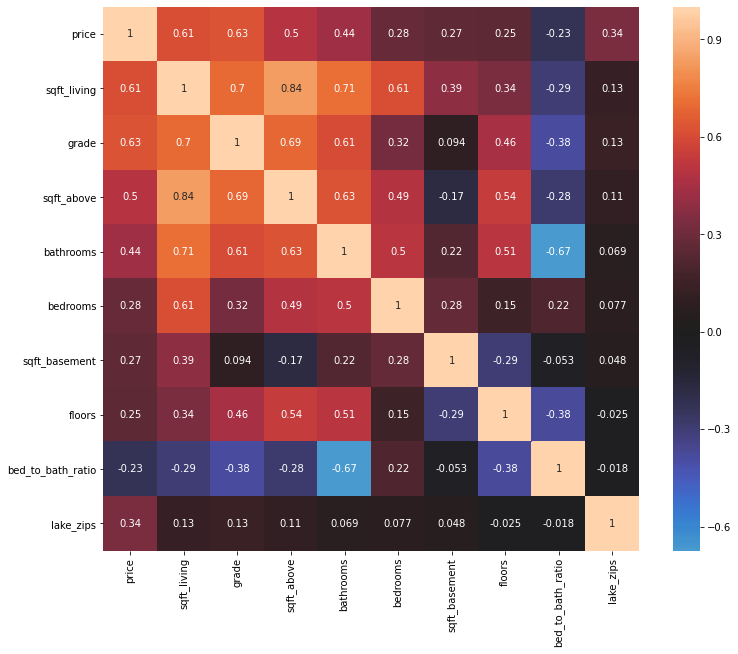

In [7]:
#Adding some color
plt.figure(figsize=(12,10))
sns.heatmap(foimatrix, center=0, annot=True);

## Removing Variables to Reduce Multicollinearity
Based on the correlation matrix above it is clear that many of the variables are highly correlated to each other. The following steps will be taken:
 * I will only use one of the sqft figures as they are highly correlated
 * I will remove floors because it has a significant correlation to other variables and a relatively low correlation to price
 * Bedrooms and bathrooms are correlated and I would like to rather use the bed-to-bath ratio to capture the bedroom dynamic. I will retain bathrooms for now

## Building the Model

In [8]:
def make_ols_sm(df, cols, add_constant=False, target='price'):
    x = df[cols]
    if add_constant:
        x = sm.add_constant(x)
    ols = sm.OLS(df[target], x)
    res = ols.fit()
    print(res.summary())
    return res

In [9]:
# cols = ['sqft_living', 'grade', 'bathrooms', 'bed_to_bath_ratio', 'lake_zips']
cols = ['grade', 'bed_to_bath_ratio', 'lake_zips']

res = make_ols_sm(df, cols)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                          4.290e+04
Date:                Thu, 29 Oct 2020   Prob (F-statistic):                        0.00
Time:                        17:42:33   Log-Likelihood:                     -2.6306e+05
No. Observations:               19301   AIC:                                  5.261e+05
Df Residuals:                   19298   BIC:                                  5.261e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### Model Conclusions
* All P values are low indicating significance of each the variables.  
* A coefficient of determination, or R-squared, at 87% indicates a highly predictive model.
* In other words 87% of the variation in dependent variables are explained by the independent variables.
* A Durbin-Watson of 2 means that there is no autocorrelation amongst the residuals.
* The high Jarque-Bera indicates that the residuals are not normally distributed which is an issue.




### A closer look at the residuals
 * Examine Histogram
 * Plot of residuals versus price
 * Q-Q plot to test for normality|
 * VIF Factor analysis to test for multicollinearity

In [10]:
def plot_residuals(df, res, target='price'):
    plt.hist(res.resid)
    plt.xticks(rotation=90)
    plt.show()
    
    plt.scatter(df[target], res.resid)
    plt.hlines(y=0, xmin=0, xmax=df[target].max())
    plt.xticks(rotation=90)
    plt.xlabel(target)
    plt.ylabel('Residuals')
    plt.show()

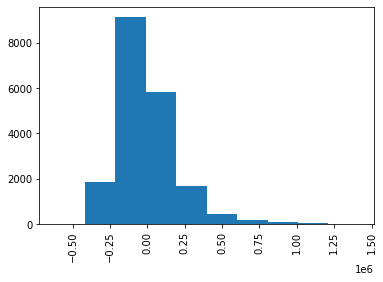

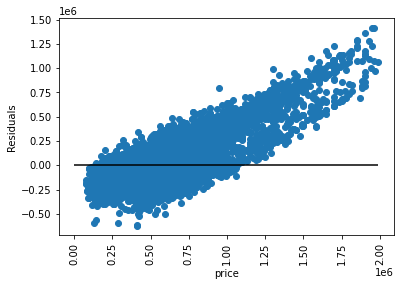

In [11]:
#histogram of residuals and a plot versus price
plot_residuals(df, res)

Residuals are trending and suggest a non-linear relationship between the independent variables and price.  A polynomial model may be more appropriate.  Further research is required.

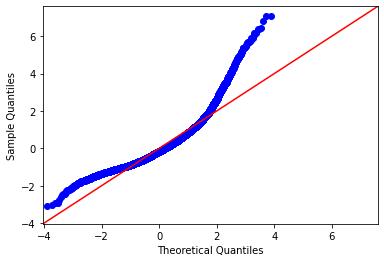

In [12]:
#q-q plot to look at normality
fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)

In [17]:
X = df[['grade', 'bed_to_bath_ratio', 'lake_zips']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,6.001710,grade
1,5.909618,bed_to_bath_ratio
2,1.056583,lake_zips


There does not appear to be significant multi-collinearity between the independent variables

### Residual Analysis conclusions
 * Looks like significant heteroskedasticity exists.  The residuals vary with price.  There is more noise in the model as price increases.  There appears to be a non-linear relationship between the independent variables and price.  If I had more time I would explore a non-linear predictive model